In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import scipy.io

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load EEG Features ===
DATA_PATH = "D:/SEED_IV/SEED_IV/eeg_feature_smooth"

def pad_or_truncate(features, target_length):
    current_length = len(features)
    if current_length < target_length:
        return np.pad(features, (0, target_length - current_length), mode='constant')
    else:
        return features[:target_length]

def load_eeg_features(sessions=["1", "2", "3"], feature_type="de_movingAve", num_channels=62):
    data, labels = [], []
    max_length = 0

    for session in sessions:
        session_path = os.path.join(DATA_PATH, session)
        if not os.path.exists(session_path):
            continue

        for file in os.listdir(session_path):
            if not file.endswith(".mat"):
                continue

            mat = scipy.io.loadmat(os.path.join(session_path, file))
            for trial in range(1, 25):
                key = f"{feature_type}{trial}"
                if key not in mat:
                    continue

                feature_matrix = mat[key]
                if feature_matrix.shape[0] != num_channels:
                    continue

                trial_features = feature_matrix.reshape(-1)
                max_length = max(max_length, len(trial_features))
                data.append(trial_features)
                labels.append((trial - 1) % 3)

    if not data:
        return np.array([]), np.array([])

    data_fixed = np.array([pad_or_truncate(x, max_length) for x in data])
    return np.array(data_fixed), np.array(labels)

# === Load & Normalize Data ===
X_fixed, y = load_eeg_features()
scaler = StandardScaler()
X_fixed = scaler.fit_transform(X_fixed)

X_tensor = torch.tensor(X_fixed, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

# === SE Block Definition ===
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# === EEGNet Optimized with SE Block ===
class EEGNetSE(nn.Module):
    def __init__(self, num_classes=3, input_channels=62, input_samples=320):
        super(EEGNetSE, self).__init__()

        self.temporal_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(16, momentum=0.01),
            nn.ELU(),
            nn.Dropout(0.25)
        )

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_channels, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ELU(),
            nn.Dropout(0.25)
        )

        self.separable_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(64, momentum=0.01),
            nn.ELU(),
            nn.Dropout(0.25)
        )

        self.se_block = SEBlock(64)

        self.fc1 = nn.Linear(1, 1)  # dummy init — will rebuild dynamically
        self.num_classes = num_classes

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch, 1, channels, samples]
        x = self.temporal_conv(x)
        x = self.depthwise_conv(x)
        x = self.separable_conv(x)
        x = self.se_block(x)

        x = x.flatten(start_dim=1)

        if isinstance(self.fc1, nn.Linear) and self.fc1.in_features != x.shape[1]:
            self.fc1 = nn.Sequential(
                nn.Linear(x.shape[1], 128),
                nn.ELU(),
                nn.Dropout(0.3),
                nn.Linear(128, self.num_classes)
            ).to(x.device)

        return self.fc1(x)

# === Model Setup ===
model = EEGNetSE(num_classes=3, input_channels=62, input_samples=320).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# === Training Loop ===
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_X = batch_X.view(-1, 62, 320)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

print("✅ EEGNet+SE Training Complete!")

# === Evaluation ===
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_X = batch_X.view(-1, 62, 320)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# === Metrics ===
acc = accuracy_score(all_targets, all_preds)
report = classification_report(all_targets, all_preds, digits=4)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:\n", report)


Epoch [1/50], Loss: 55.6877
Epoch [2/50], Loss: 50.8925
Epoch [3/50], Loss: 47.1998
Epoch [4/50], Loss: 44.6039
Epoch [5/50], Loss: 41.1549
Epoch [6/50], Loss: 38.0397
Epoch [7/50], Loss: 34.1452
Epoch [8/50], Loss: 31.7392
Epoch [9/50], Loss: 29.5755
Epoch [10/50], Loss: 27.1181
Epoch [11/50], Loss: 26.0508
Epoch [12/50], Loss: 24.5594
Epoch [13/50], Loss: 23.4126
Epoch [14/50], Loss: 22.3308
Epoch [15/50], Loss: 20.6794
Epoch [16/50], Loss: 20.7547
Epoch [17/50], Loss: 19.6755
Epoch [18/50], Loss: 19.3578
Epoch [19/50], Loss: 19.1798
Epoch [20/50], Loss: 18.3232
Epoch [21/50], Loss: 17.3518
Epoch [22/50], Loss: 16.6361
Epoch [23/50], Loss: 16.9282
Epoch [24/50], Loss: 16.2897
Epoch [25/50], Loss: 16.3657
Epoch [26/50], Loss: 16.1119
Epoch [27/50], Loss: 15.0934
Epoch [28/50], Loss: 15.1321
Epoch [29/50], Loss: 15.3697
Epoch [30/50], Loss: 14.6092
Epoch [31/50], Loss: 14.7090
Epoch [32/50], Loss: 14.5199
Epoch [33/50], Loss: 14.6995
Epoch [34/50], Loss: 14.2659
Epoch [35/50], Loss: 14

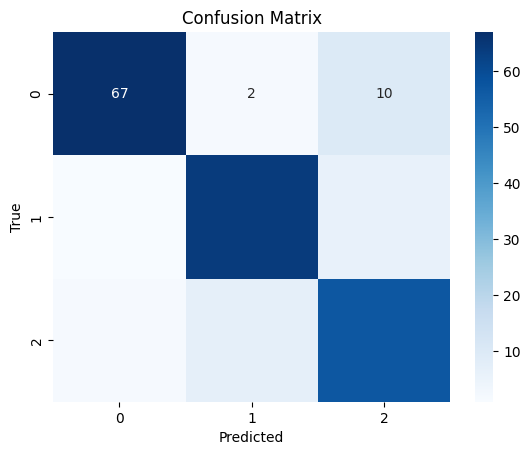

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [3]:
from torchinfo import summary

summary(model, input_size=(16, 62, 320))  # 16 is a dummy batch size


Layer (type:depth-idx)                   Output Shape              Param #
EEGNetSE                                 [16, 3]                   --
├─Sequential: 1-1                        [16, 16, 62, 321]         --
│    └─Conv2d: 2-1                       [16, 16, 62, 321]         1,024
│    └─BatchNorm2d: 2-2                  [16, 16, 62, 321]         32
│    └─ELU: 2-3                          [16, 16, 62, 321]         --
│    └─Dropout: 2-4                      [16, 16, 62, 321]         --
├─Sequential: 1-2                        [16, 32, 1, 321]          --
│    └─Conv2d: 2-5                       [16, 32, 1, 321]          1,984
│    └─BatchNorm2d: 2-6                  [16, 32, 1, 321]          64
│    └─ELU: 2-7                          [16, 32, 1, 321]          --
│    └─Dropout: 2-8                      [16, 32, 1, 321]          --
├─Sequential: 1-3                        [16, 64, 1, 322]          --
│    └─Conv2d: 2-9                       [16, 64, 1, 322]          32,768
│    

In [6]:
import torch
from sklearn.metrics import classification_report, accuracy_score

# === Define Brain Regions by Channel Indices ===
region_channels = {
    'Frontal': list(range(0, 14)),     # 14 channels
    'Central': list(range(14, 34)),    # 20 channels
    'Parietal': list(range(34, 46)),   # 12 channels
    'Occipital': list(range(46, 56)),  # 10 channels
    'Temporal': list(range(56, 62))    # 6 channels
}

# === Padding Function to Match Channel Dimension ===
def pad_channels(X_region, total_channels=62):
    """
    Pads region-specific input tensors with zeros to match the expected input channel size.
    """
    padded = torch.zeros((X_region.shape[0], total_channels, X_region.shape[2]))
    padded[:, :X_region.shape[1], :] = X_region
    return padded

# === Region-wise Evaluation Function ===
def evaluate_region_wise(model, X_tensor, y_tensor, region_channels_dict):
    model.eval()
    region_results = {}

    for region_name, channels in region_channels_dict.items():
        X_region = X_tensor[:, channels, :]  # Select region-specific channels

        all_preds = []
        all_targets = []

        for i in range(0, X_region.shape[0], 16):  # batch size = 16
            batch_X = X_region[i:i+16]
            batch_y = y_tensor[i:i+16]

            # Pad to 62 channels
            batch_X = pad_channels(batch_X).to(device)
            batch_y = batch_y.to(device)

            with torch.no_grad():
                outputs = model(batch_X)
                preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

        acc = accuracy_score(all_targets, all_preds)
        report = classification_report(all_targets, all_preds, digits=4, output_dict=True)
        region_results[region_name] = {"accuracy": acc, "report": report}

    return region_results

# === Run Region-wise Evaluation ===
print("\n📊 Running Region-wise Analysis...")
X_input = X_tensor.view(-1, 62, 320)  # reshape for 2D input format
region_results = evaluate_region_wise(model, X_input, y_tensor, region_channels)

# === Print Results for Each Region ===
for region, stats in region_results.items():
    print(f"\n🧠 Region: {region}")
    print(f"Accuracy: {stats['accuracy']:.4f}")
    print("Classification Report:")
    for label, metrics in stats['report'].items():
        if label in ['0', '1', '2']:
            print(f"  Class {label}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1-score']:.4f}")



📊 Running Region-wise Analysis...

🧠 Region: Frontal
Accuracy: 0.7870
Classification Report:
  Class 0: Precision: 0.7778, Recall: 0.7778, F1: 0.7778
  Class 1: Precision: 0.7845, Recall: 0.7889, F1: 0.7867
  Class 2: Precision: 0.7989, Recall: 0.7944, F1: 0.7967

🧠 Region: Central
Accuracy: 0.3750
Classification Report:
  Class 0: Precision: 0.3856, Recall: 0.1639, F1: 0.2300
  Class 1: Precision: 0.4574, Recall: 0.5667, F1: 0.5062
  Class 2: Precision: 0.2952, Recall: 0.3944, F1: 0.3377

🧠 Region: Parietal
Accuracy: 0.2731
Classification Report:
  Class 0: Precision: 0.2812, Recall: 0.4889, F1: 0.3570
  Class 1: Precision: 0.2587, Recall: 0.1861, F1: 0.2165
  Class 2: Precision: 0.2667, Recall: 0.1444, F1: 0.1874

🧠 Region: Occipital
Accuracy: 0.3444
Classification Report:
  Class 0: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Class 1: Precision: 0.4029, Recall: 0.1556, F1: 0.2244
  Class 2: Precision: 0.3431, Recall: 0.8778, F1: 0.4934

🧠 Region: Temporal
Accuracy: 0.3204
Class

C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)